In [1]:
import numpy as np
import math,os,glob
import pandas as pd
from pylab import *
from netCDF4 import Dataset
import pylab as pl
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm
from scipy.stats import f as scist

import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/*.csv'))
print len(nc_filename)
print("found *.csv file: \n{}".format(nc_filename))



12
found *.csv file: 
['/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed4.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed6.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_1_ref5.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_Pacific_lat52.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_Pacific_lat53.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_p_32_1.csv

In [2]:
file_num=5
marker=['s','s','s','s','s','s']

WLS_err1=np.empty([file_num,1])
WLS_coef1=np.empty([file_num,1])
WLS_errc=np.empty([file_num,1])
WLS_coefc=np.empty([file_num,1])
sinking_rate=np.empty([file_num,1])

err1=np.empty([file_num,1])
err2=np.empty([file_num,1])

rss1=np.empty([file_num,1])
rss2=np.empty([file_num,1])


1991 ARCTIC EXPEDITION Stn1
df:(1,3)
F ratio: 4.20077266195
ftest:0.132817786116
sinking   :1.424674e+03,error:9.156557e+02

1991 ARCTIC EXPEDITION Stn2
df:(1,2)
F ratio: 2.22219638363
ftest:0.274525747758
sinking   :1.239851e+03,error:1.267190e+03

1991 ARCTIC EXPEDITION Stn3
df:(1,4)
F ratio: 55.0535763397
ftest:0.00176091336298
sinking   :1.205851e+03,error:3.252660e+02

1991 ARCTIC EXPEDITION Stn4
df:(1,3)
F ratio: 17.6463274531
ftest:0.0246203845238
sinking   :1.731415e+03,error:8.102152e+02

1991 ARCTIC EXPEDITION Stn6
df:(1,3)
F ratio: 0.875279760199
ftest:0.418513515257
sinking   :5.400145e+02,error:3.610341e+02


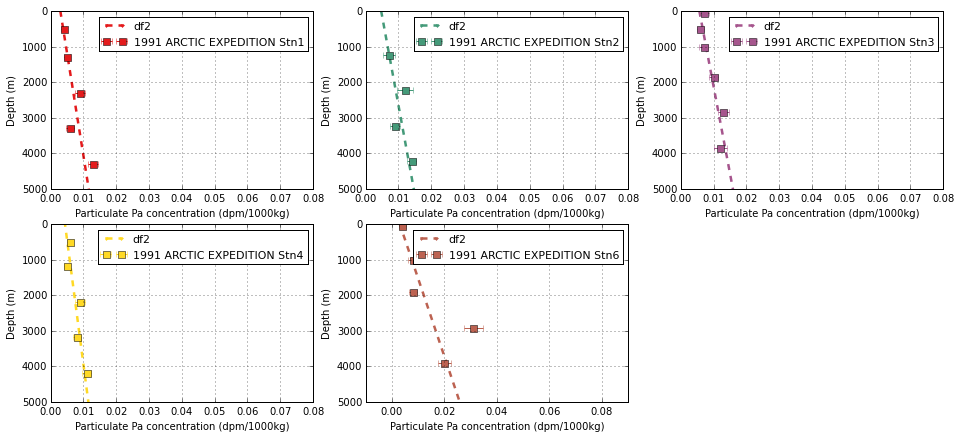

In [3]:
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y0= data['depth'];
    name= data['name'][0];
    x0=data['231Pa part.'];
    lon = data['long.'];
    lat = data['lat.'];
    err0 =data['Pa_part_err']
    
    x=np.ma.masked_where(x0<=0,x0)
    y=np.ma.masked_where(x0<=0,y0)
    err=np.ma.masked_where(x0<=0,err0)
    
    x=np.ma.masked_where(x<=0,x)
    y=np.ma.masked_where(x<=0,y)
    err=np.ma.masked_where(x<=0,err)
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    
    if j==4:
        x=np.delete(x,1,0)
        y=np.delete(y,1,0)
        err=np.delete(err,1,0)
    
    y2 = sm.add_constant(y,prepend=False)
    #y2=y
    res_wls = sm.WLS(x, y2, weights=1./err**2).fit()
    
    ftest=sm.WLS(x, y, weights=1./err**2).fit()


    model1=np.sum(ftest.resid**2/err**2)
    model2=np.sum(res_wls.resid**2/err**2)
    rss1[j]=model1
    rss2[j]=model2
    
    p1 = 1
    p2 = 2
    n = len(x)
    #F = (ftest.mse_resid - res_wls.mse_resid)/(res_wls.mse_resid) *(n-p2)/(p2-p1)
    F = ( model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    
    WLS_err1[j,:] = res_wls.bse[0]
    WLS_coef1[j,:] = res_wls.params[0]
    WLS_coefc[j,:]=res_wls.params[1]
    WLS_errc[j,:]=res_wls.bse[1]
    sinking_rate[j,:]=0.00246/res_wls.params[0]
    #err1[j]=(WLS_err1[j,:]/WLS_coef1[j,:])*1./WLS_coef1[j,:]*0.00246
    pre_err1=1./(WLS_coef1[j,:]-WLS_err1[j,:])*0.00246
    err1[j]=pre_err1-sinking_rate[j,:]
    
    
    print ('')
    print (name)
    print ('df:(%s,%s)'%(p2-p1,n-p2))
    print ('F ratio: %s'%F)
    print ('ftest:%s'%p)
    print ('sinking   :%e,error:%e'%(sinking_rate[j,:],err1[j]))


    #ax = plt.subplot()
    ax = plt.figure(1,figsize=(16,7))
    ax = plt.subplot(2,3,j+1)
    cc=cm.Set1(j*50)#Spectral(j*23)
    #ax.plot([0, 0.07],[0, 0.07]/ftest.params[0], ':',c=cc,linewidth=2.5,label='df1')
    ax.plot([0, 0.07],[0, 0.07]/res_wls.params[0]-res_wls.params[1]/res_wls.params[0], '--.',c=cc,linewidth=2.5,label='df2')
    ax.errorbar(x, y,xerr=err, fmt=marker[j],markersize=7,c=cc,label=name)
    if j==4:
        ax.scatter(x0[1],y0[1],marker='x',c='r',s=40)
    ax.legend(loc=0,fontsize=11)
    
    ax.set_ylim([0, 5000])
    #ax.set_xlim([0, 0.035])
#    if j+1==1 or j+1==4:
    plt.ylabel('Depth (m)')
#    if j+1==5:
    plt.xlabel('Particulate Pa concentration (dpm/1000kg)')
#    if j+1==1 or j+1==2 or j+1==3:
#        plt.setp(ax.get_xticklabels(), visible=False)
#    if not (j+1==1 or j+1==4):
#        plt.setp(ax.get_yticklabels(), visible=False)
#    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)

    plt.grid()
    plt.gca().invert_yaxis()
    #plt.tight_layout()
plt.show()

In [4]:
#f_test whether the intercepts were necessary
p1 = 1
p2 = 2
n = 24
F = (sum(rss1) - sum(rss2))/(sum(rss2)) *(n-p2*5)/(p2*5-p1*5)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('df:(%s,%s)'%((p2-p1)*5,(n-p2*5)))
print ('F ratio: %s'%F)
print ('ftest:%s'%p)

df:(5,14)
F ratio: 5.97843721885
ftest:0.0229508744775


In [5]:
WLS_err2=np.empty([file_num,1])
Kvalue=np.empty([file_num,1])
Jvalue=np.empty([file_num,1])
WLS_coef2=np.empty([file_num,1])
Kapa=np.empty([file_num,1])


1991 ARCTIC EXPEDITION Stn1
K   :[ 0.01045738],err:[ 0.0053314]
J   :[ 0.30529706],err:[ 0.40267212]

1991 ARCTIC EXPEDITION Stn2
K   :[ 0.00991747],err:[ 0.0118492]
J   :[ 0.31624604],err:[ 0.78265727]

1991 ARCTIC EXPEDITION Stn3
K   :[ 0.00454194],err:[ 0.001847]
J   :[ 0.32789541],err:[ 0.2867188]

1991 ARCTIC EXPEDITION Stn4
K   :[ 0.00912052],err:[ 0.00406297]
J   :[ 0.28059319],err:[ 0.31377228]

1991 ARCTIC EXPEDITION Stn6
K   :[ 0.01572319],err:[ 0.01325654]
J   :[ 0.33619292],err:[ 0.54847203]


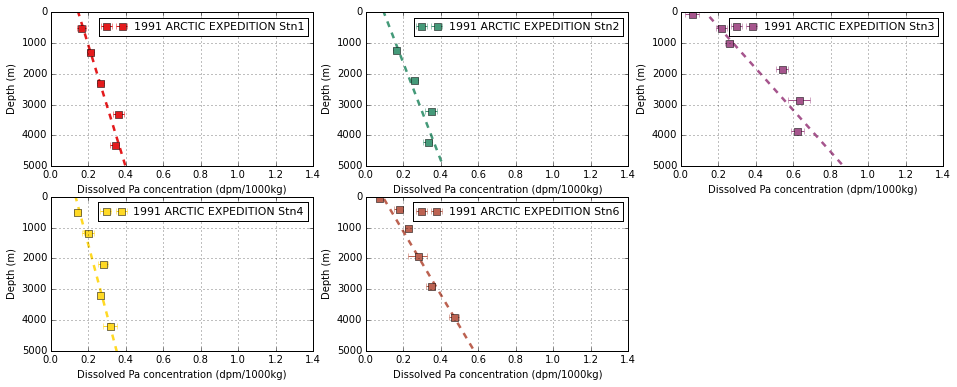

In [6]:


for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    x= data['231Pa diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_diss_err']
    x=np.ma.masked_where(x<=0,x)
    y=np.ma.masked_where(x<=0,y)
    err=np.ma.masked_where(x<=0,err)      
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    
    y2=y

    #fit: model2
    y3 = sm.add_constant(y2,prepend=False)  
    res_wls2 = sm.WLS(x,y3, weights=1./err**2).fit() 
    WLS_coef2[j]=res_wls2.params[0]
    WLS_err2[j]=res_wls2.bse[0]
    
    Q=0.00246
    #Kvalue[j]=1/res_wls2.params[0]
    #err2=res_wls2.bse[0]/res_wls2.params[0]*Kvalue[j]
    a=res_wls2.params[0]
    b=res_wls2.params[1]
    
    Kvalue[j]=Q**2/(b*Q+WLS_coefc[j,:]*a*sinking_rate[j,:])
        
    pre=Q**2/((b*Q+WLS_coefc[j,:]*a*sinking_rate[j,:])**2)
    pre_err2=abs(Q*pre*res_wls2.bse[1])+abs(a*WLS_coefc[j,:]*pre*err1[j])+abs(a*sinking_rate[j,:]*WLS_errc[j,:]*pre)
    err2[j]=pre_err2
    

    
    Jvalue[j]=a*sinking_rate[j,:]/Q*Kvalue[j]
    err3=abs(Kvalue[j]*sinking_rate[j,:]/Q*res_wls2.bse[0])
    err3=err3+abs(a*sinking_rate[j,:]/Q*err2[j])+abs(a*Kvalue[j]/Q*err1[j])
    
    #fit: model1
    ftest=sm.WLS(x, y2, weights=1./err**2).fit()
    #collect model1 result
    
    #calculate weighted resid. sum
    resid1=ftest.resid**2/err**2                
    model1=np.sum(resid1)

    resid2=res_wls2.resid**2/err**2
    model2=np.sum(resid2)
    
    #prepare data to recalculate the whole profile later
    rss1[j]=model1                
    rss2[j]=model2

    #f_test
    p1 = 1
    p2 = 2
    n = len(x)
    F = (model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    
    #print related data
    print ('')
    print (name)
    print ('K   :%s,err:%s'%(Kvalue[j,:],err2[j]))
    print ('J   :%s,err:%s'%(Jvalue[j,:],err3))
    #print ('F ratio: %s'%F)
    #print ('df:(%s,%s)'%(p2-p1,n-p2))
    #print ('ftest:%s'%p)
    
    #plot
    ax = plt.figure(1,figsize=(16,16))
    ax = plt.subplot(5,3,j+1)
    cc=cm.Set1(j*50)
    #ax.plot(y2, ftest.fittedvalues, ':',c=cc,linewidth=2.5,label='df1')
    ax.plot([0, 1.4],[0, 1.4]/res_wls2.params[0]-res_wls2.params[1]/res_wls2.params[0], '--.',c=cc,linewidth=2.5)
    ax.errorbar(x,y2,xerr=err, fmt=marker[j],markersize=7,c=cc,label=name)   
    ax.legend(loc=0,fontsize=11)
    
#    ax.set_ylim([0, 0.7])
#    ax.set_xlim([0, 0.02])
#    if j+1==1 :
    plt.ylabel('Depth (m)')
#    if j+1==4:
#        plt.ylabel('Dissolved Pa concentration')
#    if j+1==3 or j+1==4 or j+1==5:
    plt.xlabel('Dissolved Pa concentration (dpm/1000kg)')
#    if j+1==1 or j+1==2:
#        plt.setp(ax.get_xticklabels(), visible=False)
#    if not (j+1==1 or j+1==4):
#        plt.setp(ax.get_yticklabels(), visible=False)
#    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)
    ax.set_ylim([0, 5000])
    plt.gca().invert_yaxis()
    plt.grid() 
#    print(name,'p_value',round(res_wls2.pvalues[0],3),'C',round(res_wls2.params[1],3))
#    print(name,'k_pa',1/res_wls2.params[0])
plt.show()

In [7]:
p1 = 1
p2 = 2
n = 26
F = (sum(rss1) - sum(rss2))/(sum(rss2)) *(n-p2*5)/(p2*5-p1*5)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('df:(%s,%s)'%((p2-p1)*5,(n-p2*5)))
print ('F ratio: %s'%F)
print ('ftest:%s'%p)

df:(5,16)
F ratio: 13.6457867643
ftest:0.00113717264715


In [8]:
marker=['s','s','s','s','s','s']
i= np.array([98,98,97.6,97.6,95.2])

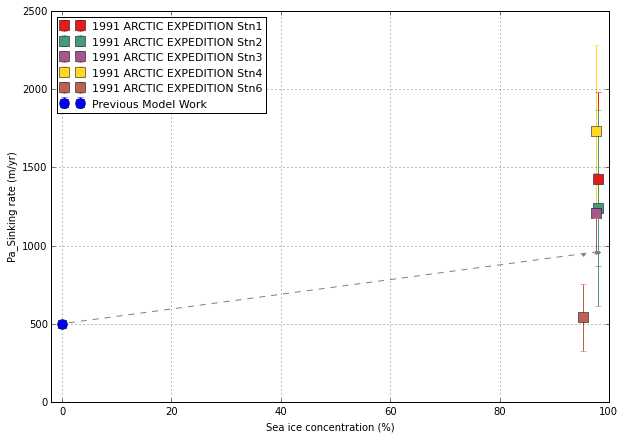

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            WLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     5.143
Date:                Wed, 09 Mar 2016   Prob (F-statistic):             0.0859
Time:                        14:12:37   Log-Likelihood:                -9.1134
No. Observations:                   6   AIC:                             22.23
Df Residuals:                       4   BIC:                             21.81
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             4.7064      2.075      2.268      0.086        -1.056    10.468
const        499.9998      1.354    369.412      0.0

In [9]:
##WLS: sinking rate and the ice concentration    
err1=(WLS_err1/WLS_coef1)*1/WLS_coef1*0.00246
sinking_rate=np.append(sinking_rate,500)
i=np.append(i,0)
err1=np.append(err1,1)
i2 = sm.add_constant(i,prepend=False)
mod_wls3 = sm.WLS(sinking_rate,i2,weights=1./err1**2) #Is it the real error?
res_wls3 = mod_wls3.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls3.fittedvalues, '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)

ax.errorbar(i[-1],sinking_rate[-1], yerr=err1[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0, fontsize=11)#,bbox_to_anchor=(1.45,1))
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Sinking rate (m/yr)')

#ax.set_ylim([0, 5000])
ax.set_xlim([-2, 100])
plt.grid()
plt.show()
print res_wls3.summary()
print res_wls3.params

In [10]:
from statsmodels.formula.api import wls
from scipy.stats import f as scist
data = pd.DataFrame({'sinking_rate':sinking_rate, 'i3': i})
res_wls5 = wls('sinking_rate~i3', data,weights=1./(err1**2)).fit()
a=average(sinking_rate)
print a
rss=(sinking_rate-a)**2/err1**2
rss_sum=sum(rss)
p1 = 1
p2 = 2
n = file_num
F = (rss_sum - np.sum(res_wls5.resid**2/err1**2))/(np.sum(res_wls5.resid**2/err1**2)) *(n-p2)/(p2-p1)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('F ratio: %s'%F)
print ('df:(%s,%s)'%((p2-p1),(n-p2)))
print ('ftest:%s'%p)

1106.96749432
F ratio: 150825.796958
df:(1,3)
ftest:3.76484358133e-08


[[ 0.00341037]
 [ 0.00663625]
 [ 0.011856  ]
 [ 0.00363948]
 [ 0.00474275]]


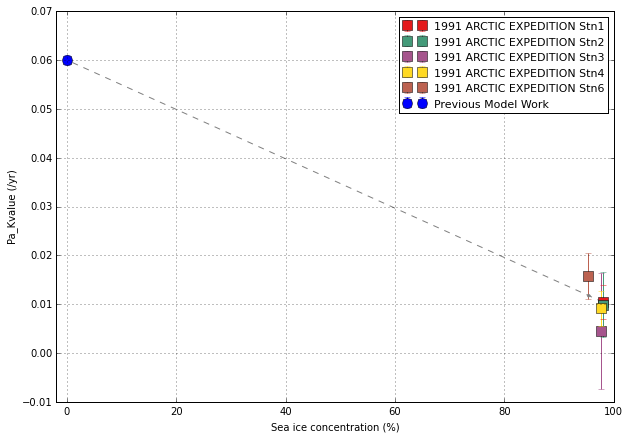

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1666.
Date:                Wed, 09 Mar 2016   Prob (F-statistic):           2.15e-06
Time:                        14:12:37   Log-Likelihood:                -3.4532
No. Observations:                   6   AIC:                             10.91
Df Residuals:                       4   BIC:                             10.49
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0005   1.24e-05    -40.811      0.000        -0.001    -0.000
const          0.0600      0.001    113.876      0.0

In [11]:
##WLS: K value and the ice concentration


#err2=WLS_err2/WLS_coef2*Kvalue
pre_err2= (((WLS_errc/WLS_coefc)**2+(WLS_err2/WLS_coef2)**2)*((WLS_coefc*WLS_coef2)**2))**(0.5)
err2=((WLS_err2)**2+ (pre_err2)**2)**0.5/Q
print err2
#(WLS_coef1**(-4)*(WLS_coef2**(-2))*(WLS_err1)**2+WLS_coef2**(-4)*(WLS_coef1**(-2))*(WLS_err2)**2)**(0.5)
#((WLS_err1/WLS_coef1)**2+(WLS_err2/WLS_coef2)**2)**(0.5) # error of k value K-1=1

Kvalue=numpy.append(Kvalue,0.06)#0.06
err2=numpy.append(err2,0.001)

mod_wls4 = sm.WLS(Kvalue, i2, weights=1./(err2**2))
res_wls4 = mod_wls4.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls4.fittedvalues,  '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Kvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)
errorbar(i[-1],Kvalue[-1], yerr=err2[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Kvalue (/yr)')
ax.set_xlim([-2, 100])
plt.grid()
plt.show()
print res_wls4.summary()

In [12]:
#rearrage data. to make it increase 
min=0;i3=[]
k3=[];e3=[]
i22=np.copy(i2[:,0])

for j in range (len(i22)):
    k=np.where(i22 == i22.min())[0][0]
    i3.append(i22[k])
    e3.append(err2[k])
    i22[k]=1000
    k3.append(Kvalue[k])    

i3=np.array(i3);k3=np.array(k3);e3=np.array(e3)

y(100):0.00493334309027


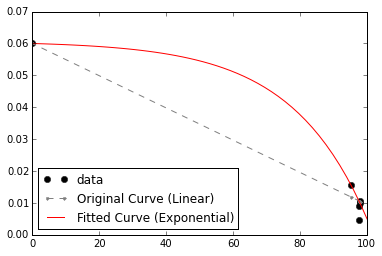

In [14]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return -a * np.exp(-b * (100-x)) + c


popt, pcov = curve_fit(func,i3,k3,sigma=e3/k3)

plt.figure()
plt.plot(i3, k3, 'ko', label="data")
#errorbar(100-i3, k3, yerr=e3, fmt='o',markersize=3,c='black',label='previous model work')
plt.plot(i, res_wls4.fittedvalues,  '--.',c='grey',label='Original Curve (Linear)')
x = np.linspace(0,100,50)
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve (Exponential)")

print 'y(100):%s'%func(100, *popt)
plt.xlim([0,100])
plt.legend(loc=3)
plt.show()

y(100):0.00493334309027


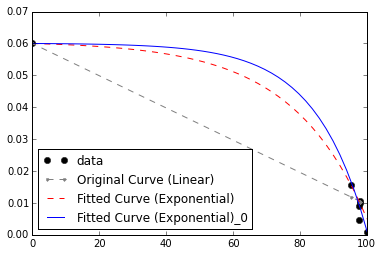

In [16]:
min=0;i3=[100]
k3=[0.001];e3=[0.000001]
i22=np.copy(i2[:,0])

for j in range (len(i22)):
    k=np.where(i22 == i22.min())[0][0]
    i3.append(i22[k])
    e3.append(err2[k])
    i22[k]=1000
    k3.append(Kvalue[k])    

i3=np.array(i3);k3=np.array(k3);e3=np.array(e3)


popt2, pcov2 = curve_fit(func,i3,k3,sigma=e3/k3)
plt.figure()
plt.plot(i3, k3, 'ko', label="data")
#errorbar(100-i3, k3, yerr=e3, fmt='o',markersize=3,c='black',label='previous model work')
plt.plot(i, res_wls4.fittedvalues,  '--.',c='grey',label='Original Curve (Linear)')
x = np.linspace(0,100,50)
plt.plot(x, func(x, *popt), 'r--', label="Fitted Curve (Exponential)")
plt.plot(x, func(x, *popt2), 'b-', label="Fitted Curve (Exponential)_0")

print 'y(100):%s'%func(100, *popt)
plt.xlim([0,100])
plt.legend(loc=3)
plt.show()

## k_1

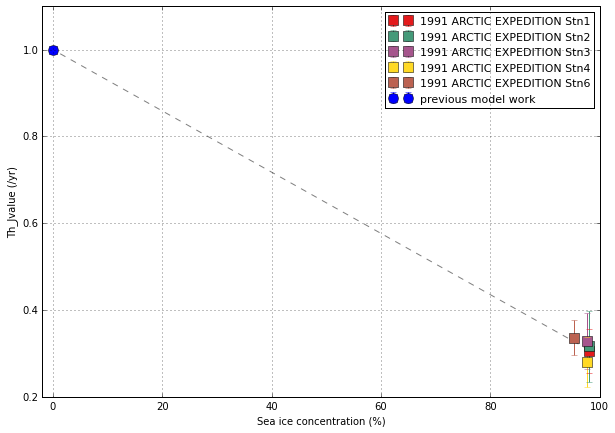

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7861.
Date:                Fri, 24 Jul 2015   Prob (F-statistic):           9.70e-08
Time:                        10:26:08   Log-Likelihood:               -0.40903
No. Observations:                   6   AIC:                             4.818
Df Residuals:                       4   BIC:                             4.402
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0071   7.96e-05    -88.660      0.000        -0.007    -0.007
const          1.0000      0.000   3151.990      0.0

In [12]:
err2=WLS_err2/WLS_coef2*Jvalue

Jvalue=numpy.append(Jvalue,1.0)
err2=numpy.append(err2,0.001)

mod_wls4 = sm.WLS(Jvalue, i2, weights=1./err2**2).fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, mod_wls4.fittedvalues,  '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Jvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)
    
errorbar(i[-1],Jvalue[-1], yerr=err2[-1], fmt='o',markersize=10,c='blue',label='previous model work')
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Th_Jvalue (/yr)')
ax.set_xlim([-2, 100])
plt.grid()
plt.show()
print mod_wls4.summary()

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


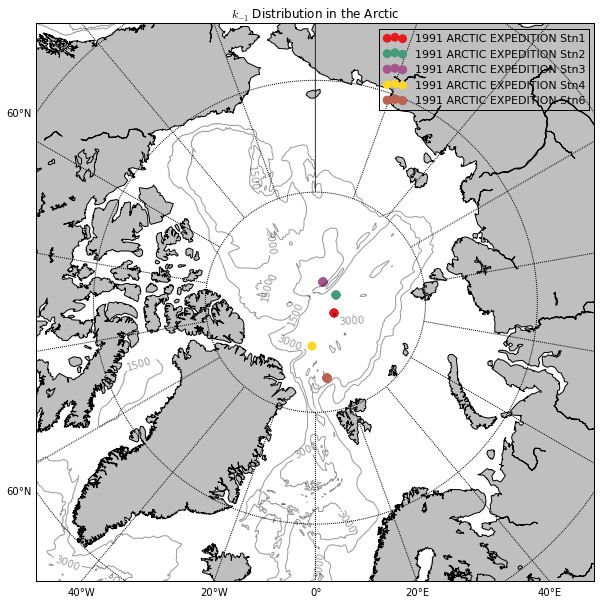

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/*.csv'))
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    name= data['name'][0];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    #x_interp[j]=x[0]
    #y_interp[j]=y[0]
    m.scatter(x,y,color=cm.Set1(j*50),s=Jvalue[j]*200,label=name)
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)
topoin = -etopodata.variables['ROSE'][:]
topoin_ma=np.ma.masked_where(topoin<=0,topoin)
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
gridx, gridy = np.meshgrid(lons, lats)
xs,ys = m(gridx,gridy)  

m = m.contour(xs,ys,topoin_ma,linewidth=0.075,colors='black',alpha=0.4)
plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')

plt.title('$k_{-1}$ Distribution in the Arctic')
plt.legend(loc=1,fontsize=11)

plt.show()

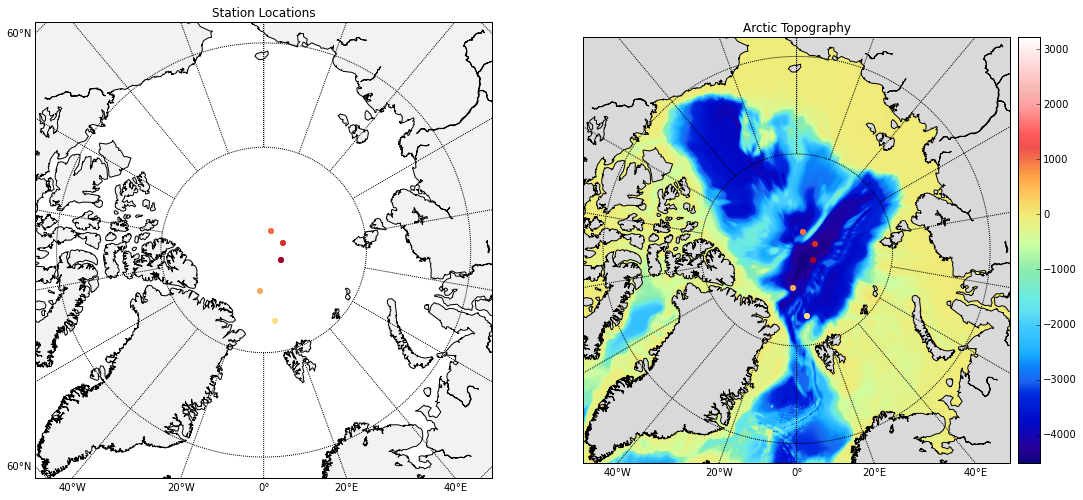

In [14]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(121)

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))
    
plt.title("Station Locations")
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

ax = fig.add_subplot(122)
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,81.,15.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))

nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
topodat = m.transform_scalar(topoin,lons,lats,nx,ny)    
from mpl_toolkits.basemap import cm    
im = m.imshow(topodat,cm.GMT_haxby)
cb = m.colorbar(im,"right", size="5%", pad='2%')
plt.title("Arctic Topography")
plt.show()